# generating the binary mask for each class

In [3]:
#importing the necessary libraries
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np



In [4]:
image_list = sorted(os.listdir("images"), key=lambda x: int(x.split('.')[0]))
annote_list = sorted(os.listdir("annotated"), key=lambda x: int(x.split('.')[0]))

print(f"the shape of the iamge_list is : {len(image_list)}")
print(f"the shape of the annote_lsit is : {len(annote_list)}")

the shape of the iamge_list is : 200
the shape of the annote_lsit is : 200


In [5]:
#function to plot the pair
def plot_pair(image, gray=False):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, figsize=(16,8))
    i = 0

    for y in range(2):
        if gray: 
            axes[y].imshow(image[i], cmap='gray')
        else:
            axes[y].imshow(image[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i+=1
    plt.show()

In [6]:
def get_poly(annotation_path):
    """
    returns the shapes data from json file
    Args:
        annotation_path: path to the annotation file
    Returns:
        Returns the dicitionary with the annotation information
    """
    with open(annotation_path) as handle:
        data = json.load(handle)
    shape_dict = data["shapes"]

    return shape_dict

In [7]:
def create_binary_mask(image, shape_dict):
    black_background = np.zeros((image.shape[0],image.shape[1]), dtype=np.float32 ) #creating a blank image of zeroes
    for shape in shape_dict:
        points = np.array(shape["points"]) #accessing all the points as np array for each shape in the json file
        cv2.fillPoly(black_background, [points], 255 ) # filling all the points in points array with white color to build binary mask
    return black_background

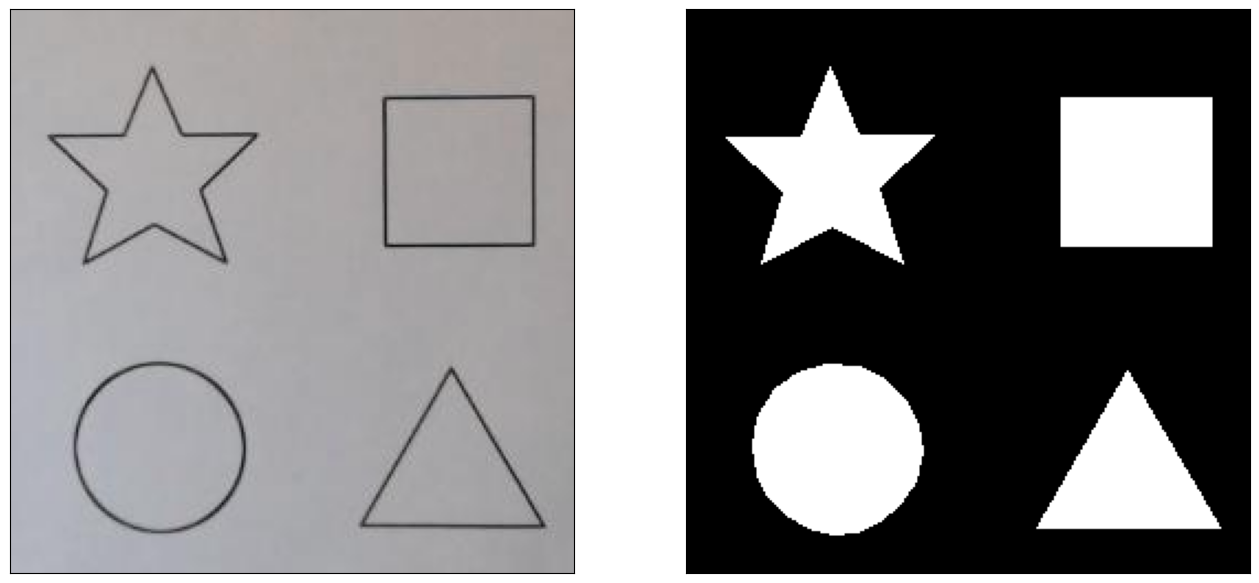

[{'label': 'star', 'line_color': None, 'fill_color': None, 'points': [[34, 115], [44, 83], [18, 58], [52, 58], [65, 26], [78, 57], [112, 57], [87, 81], [98, 115], [66, 98]], 'shape_type': 'polygon'}, {'label': 'square', 'line_color': None, 'fill_color': None, 'points': [[170, 107], [170, 40], [238, 40], [238, 107]], 'shape_type': 'polygon'}, {'label': 'circle', 'line_color': None, 'fill_color': None, 'points': [[30, 198], [32, 185], [40, 172], [50, 165], [63, 161], [78, 162], [90, 168], [99, 177], [105, 188], [107, 200], [104, 214], [97, 224], [88, 232], [77, 237], [66, 238], [55, 235], [45, 229], [36, 220], [32, 211]], 'shape_type': 'polygon'}, {'label': 'triangle', 'line_color': None, 'fill_color': None, 'points': [[159, 235], [200, 164], [242, 235]], 'shape_type': 'polygon'}]


In [8]:
for image_file, annote_file in zip(image_list, annote_list):
    # reading the image file as gray scale
    img = cv2.imread(os.path.join("images", image_file), 1)

    # reading the annote path
    annote_path = os.path.join("annotated", annote_file)

    shape_dict = get_poly(annote_path)
    binary_image = create_binary_mask(img, shape_dict) #getting the binary mask for the img file by using the annoted data
    plot_pair([img, binary_image],gray=True)
    print(shape_dict)
    break
    
    


In [9]:
for shape in shape_dict:
    print(shape["points"])

[[34, 115], [44, 83], [18, 58], [52, 58], [65, 26], [78, 57], [112, 57], [87, 81], [98, 115], [66, 98]]
[[170, 107], [170, 40], [238, 40], [238, 107]]
[[30, 198], [32, 185], [40, 172], [50, 165], [63, 161], [78, 162], [90, 168], [99, 177], [105, 188], [107, 200], [104, 214], [97, 224], [88, 232], [77, 237], [66, 238], [55, 235], [45, 229], [36, 220], [32, 211]]
[[159, 235], [200, 164], [242, 235]]


In [10]:
np.array([[34, 115], [44, 83], [18, 58], [52, 58], [65, 26], [78, 57], [112, 57], [87, 81], [98, 115], [66, 98]])

array([[ 34, 115],
       [ 44,  83],
       [ 18,  58],
       [ 52,  58],
       [ 65,  26],
       [ 78,  57],
       [112,  57],
       [ 87,  81],
       [ 98, 115],
       [ 66,  98]])

## creating multiclass mask

In [37]:
hues = {
    'star': 30,
    'square':0,
    'circle':90,
    'triangle':60
}

labels = sorted(hues.keys())

In [38]:
print(labels)

['circle', 'square', 'star', 'triangle']


In [39]:
def create_multimask(img, shape_dict):
    channels = []

    classes = [x["label"] for x in shape_dict] #extracting the claasses for each shape from the annotated json dict

    poly = [np.array(x["points"], dtype=np.int32) for x in shape_dict] # creating an np array of points for each 
    
    lable2ploy = dict(zip(classes, poly)) # python dict with shape and the corrsoponding points

    background = np.zeros(shape = img.shape[:2], dtype=np.float32) #creating a black background for each shape

    #traversing the label, point pair
    for i, label in enumerate(labels):
        blank_background = np.zeros(shape = img.shape[:2], dtype=np.float32) #creating a black background for each shape

        #checking ig the current label is there in the annote file
        if label in classes:
            cv2.fillPoly( blank_background, [lable2ploy[label]], 255) #creating a single channel image
            cv2.fillPoly( background, [lable2ploy[label]], 255)
        channels.append(blank_background) #appending the binary mask for each class to the channels
    _, thresh = cv2.threshold(background, 127, 255,  cv2.THRESH_BINARY_INV) #flipping black to white and white to black (we are adding the background)
    channels.append(thresh)

    Y = np.stack(channels, axis=2) #we stack all the binary mask on z axis
    return Y






In [40]:
for image_file, annote_file in zip(image_list, annote_list):
    # reading the image file as gray scale
    img = cv2.imread(os.path.join("images", image_file), 1)

    # reading the annote path
    annote_path = os.path.join("annotated", annote_file)

    shape_dict = get_poly(annote_path)
    print(shape_dict)
    Y = create_multimask(img, shape_dict)
    print(Y.shape)
    break

[{'label': 'star', 'line_color': None, 'fill_color': None, 'points': [[34, 115], [44, 83], [18, 58], [52, 58], [65, 26], [78, 57], [112, 57], [87, 81], [98, 115], [66, 98]], 'shape_type': 'polygon'}, {'label': 'square', 'line_color': None, 'fill_color': None, 'points': [[170, 107], [170, 40], [238, 40], [238, 107]], 'shape_type': 'polygon'}, {'label': 'circle', 'line_color': None, 'fill_color': None, 'points': [[30, 198], [32, 185], [40, 172], [50, 165], [63, 161], [78, 162], [90, 168], [99, 177], [105, 188], [107, 200], [104, 214], [97, 224], [88, 232], [77, 237], [66, 238], [55, 235], [45, 229], [36, 220], [32, 211]], 'shape_type': 'polygon'}, {'label': 'triangle', 'line_color': None, 'fill_color': None, 'points': [[159, 235], [200, 164], [242, 235]], 'shape_type': 'polygon'}]
(256, 256, 5)


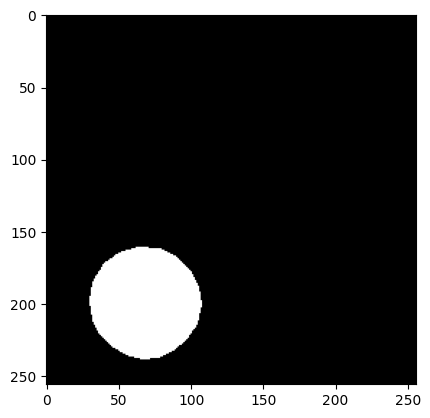

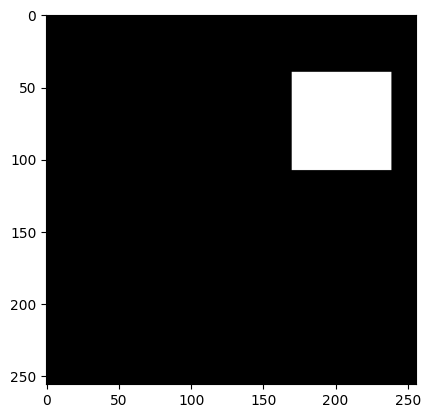

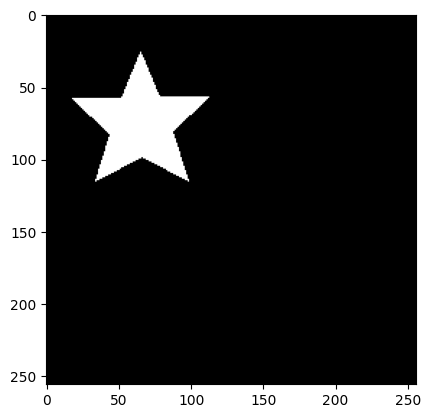

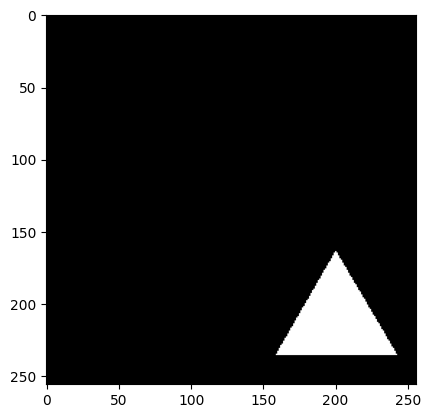

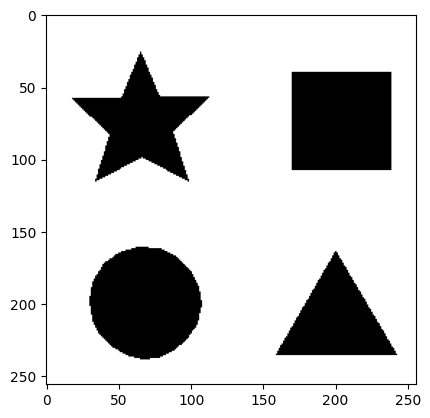

In [41]:
for i in range(5):
    mask = Y[:, :, i]
    plt.imshow(mask, cmap='grey')
    plt.show()